# M2修士論文
1. データの取得
2. GCNとVGAEの比較
3. 中心性比較

In [1]:
import sys
import torch
import torch_geometric
import networkx as nx

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)
print("PyTorch Geometric：" + torch_geometric.__version__)
print("NetworkX：" + nx.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.13.10 (main, Jan 10 2026, 11:37:40) [GCC 13.3.0]
PyTorch：2.8.0+cu129
PyTorch Geometric：2.7.0
NetworkX：3.6.1
CUDA：12.9
GPU：NVIDIA GeForce RTX 3060


## データの取得
### グラフデータの取得

- neo4jのグラフデータベースからグラフデータを取得する

In [2]:
from neo4j import GraphDatabase
import pandas as pd

# neo4j serverに接続するdriverの設定
driver = GraphDatabase.driver('neo4j://graph-db:7687')

# 取引データを取得する
def fetch_transaction(tx, excluded_addresses = []):
    """
    トランザクションを取得する関数
    
    Parameters:
    - excluded_addresses: 除外したいコントラクトアドレスのリスト
    """
    # 特定のコントラクトアドレスのみ取得
    if len(excluded_addresses) > 0:
        query = """
        MATCH p=()-[r:TRANSFER]->()
        WHERE NOT r.contractAddress IN $excluded
        RETURN p
        """
        transactions = tx.run(query, excluded=excluded_addresses)
    else:
        query = """
        MATCH p=()-[r:TRANSFER]->()
        RETURN p
        """
        transactions = tx.run(query)
    return list(transactions)

excluded_addresses = [
    "0x32F4866B63CaDeD01058540Cff9Bb1fcC05E1cb7",
    "0xe7f1725E7734CE288F8367e1Bb143E90bb3F0512",
    "0x76B50696B8EFFCA6Ee6Da7F6471110F334536321"
]  # 除外したいコントラクトアドレスのリスト
transactions = list()
relations = list()

# neo4jに接続してトランザクションを実行
with driver.session() as session:
    transactions = session.execute_read(fetch_transaction, excluded_addresses)

In [3]:
# トランザクションの結果をリストに保存
for transaction in transactions:
    path = transaction["p"]
    relationship = path.relationships[0]

    relations.append({
        "tokenId": relationship["tokenId"],
        "from": path.start_node["address"], 
        "to": path.end_node["address"],
        "gasPrice": relationship["gasPrice"],
        "gasUsed": relationship["gasUsed"],
        "contractAddress": relationship["contractAddress"],
        "tokenUri": relationship["tokenUri"],
        "blockNumber": relationship["blockNumber"],
    })

# 結果をdataframeで保存して表示
df_all_relation = pd.DataFrame(relations)

# コントラクトアドレスごとに取引数とユーザー数を集計
contract_stats = []
for contract_address in df_all_relation['contractAddress'].unique():
    contract_df = df_all_relation[df_all_relation['contractAddress'] == contract_address]
    transaction_count = len(contract_df)
    unique_users = pd.concat([contract_df['from'], contract_df['to']]).nunique()
    contract_stats.append({
        'contractAddress': contract_address,
        'transaction_count': transaction_count,
        'user_count': unique_users
    })

df_contract_summary = pd.DataFrame(contract_stats)
df_contract_summary = df_contract_summary.sort_values('transaction_count', ascending=False).reset_index(drop=True)
display(df_contract_summary)

,contractAddress,transaction_count,user_count
0,0x42069ABFE407C60cf4ae4112bEDEaD391dBa1cdB,35654,8216
1,0x620b70123fB810F6C653DA7644b5dD0b6312e4D8,9165,4618
2,0x9Ef31ce8cca614E7aFf3c1b883740E8d2728Fe91,3376,1033
3,0x6dBccC65133635D27AE56B7E3586b6e810d92082,261,25
4,0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D,146,67


In [4]:
# 取引数の少ないコントラクトアドレスをテストデータとする
df_test_relation = df_all_relation[df_all_relation["contractAddress"] == "0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D"]
df_train_relation = df_all_relation[df_all_relation["contractAddress"] != "0xAAa87514287CF537fD600BFFdd2e2d65A3A73C3D"]

# CSVに保存
data_url = "/trust-engine/2025/master_thesis_data/"
df_train_relation.to_csv(data_url + "train-relations.csv", index=True)
df_test_relation.to_csv(data_url + "test-relations.csv", index=True)

# 結果の表示
print(f"Train data num = {len(df_train_relation)}")
print(f"Test data num = {len(df_test_relation)}")

Train data num = 48456
Test data num = 146


### グラフデータの可視化

- DataFrameのデータをnetworkxデータに変換する

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

graph = nx.DiGraph()
graph.add_nodes_from(pd.concat([df_all_relation["from"], df_all_relation["to"]]).unique())
for index, transaction in df_all_relation.iterrows():
    graph.add_edge(transaction["from"], transaction["to"])
print(f"ネットワーク: ノード数={graph.number_of_nodes()}, エッジ数={graph.number_of_edges()}")

train_graph = nx.DiGraph()
train_graph.add_nodes_from(pd.concat([df_train_relation["from"], df_train_relation["to"]]).unique())
for index, transaction in df_train_relation.iterrows():
    train_graph.add_edge(transaction["from"], transaction["to"])
print(f"学習用ネットワーク: ノード数={train_graph.number_of_nodes()}, エッジ数={train_graph.number_of_edges()}")

ネットワーク: ノード数=13699, エッジ数=24886
学習用ネットワーク: ノード数=13632, エッジ数=24812


**グラフデータの可視化**

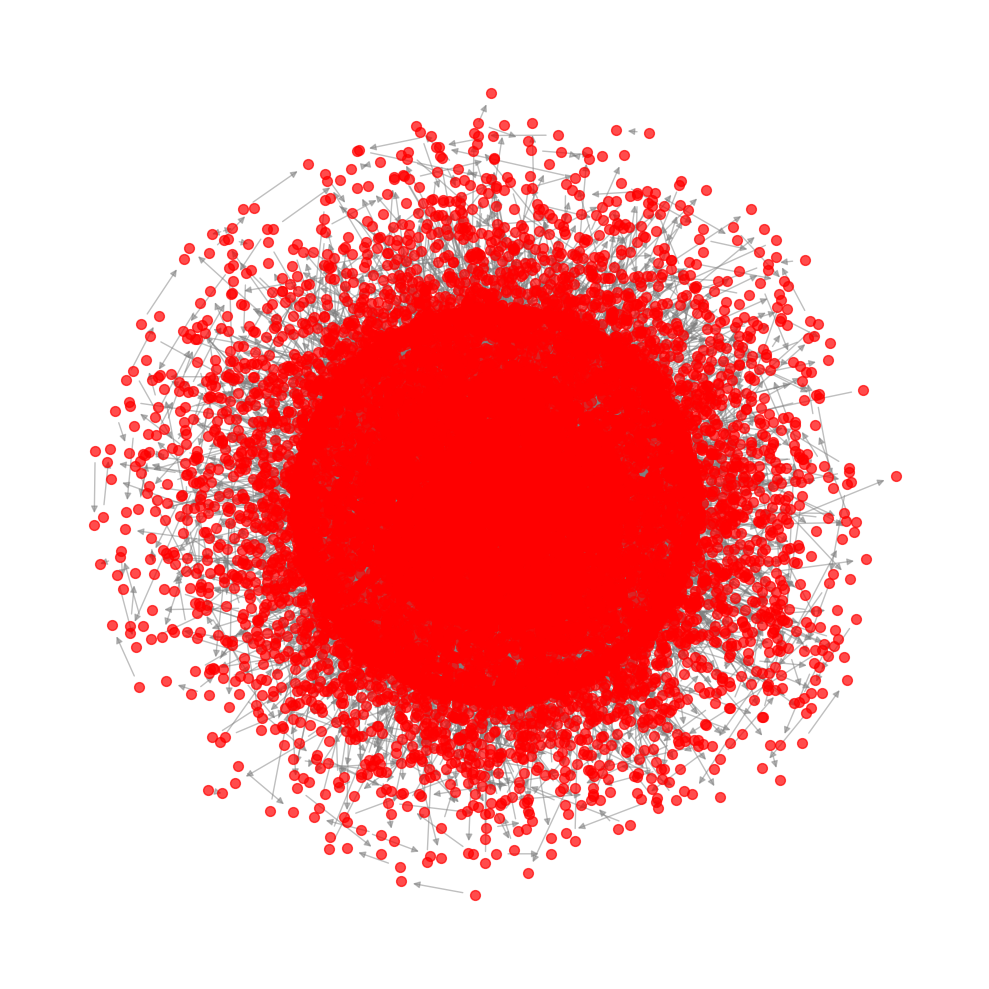

node=13699, edge=24886


In [6]:
# グラフを可視化
plt.figure(figsize=(10, 10))

# レイアウトを計算（ノード位置を決定）
pos = nx.spring_layout(graph, k=1, iterations=50)

# ノードを描画
nx.draw_networkx_nodes(graph, pos, node_color='red', node_size=50, alpha=0.7)

# エッジを描画
nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5, arrows=True, arrowsize=10)

plt.axis('off')  # 軸を非表示
plt.tight_layout()
plt.savefig(data_url + "transaction-network.png")
plt.show()

print(f"node={graph.number_of_nodes()}, edge={graph.number_of_edges()}")

**次数分布の可視化**

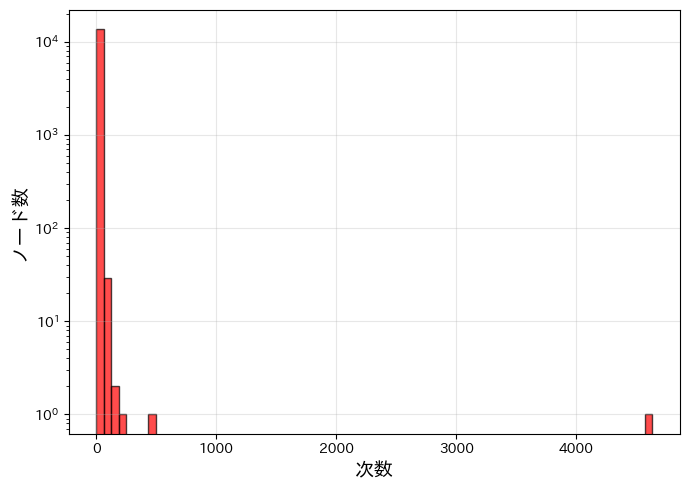

In [ ]:
# 次数分布を計算
total_degrees = [graph.in_degree(n) + graph.out_degree(n) for n in graph.nodes()]

# 次数分布の可視化
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

# 全次数分布
axes.hist(total_degrees, bins=75, color='red', alpha=0.7, edgecolor='black')
axes.set_yscale('log')  # y軸を対数スケールに設定
axes.set_xlabel('次数', fontsize=14)
axes.set_ylabel('ノード数', fontsize=14)
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(data_url + "degree-distribution.png")
plt.show()

### 頂点特徴量を求める
- NFT取引においてユーザーの頂点特徴量は利用できないためネットワーク構造とトランザクション情報を取り扱う
- 中心性を用いてネットワークの構造を捉える
- ガス代とブロック番号からトランザクション情報をとらえる
    - ガス代: トランザクションの重要度
    - ブロック番号: トランザクションの時系列情報

In [8]:
# 中心性の計算
degree = nx.in_degree_centrality(train_graph)
betweenness = nx.betweenness_centrality(train_graph)
pagerank = nx.pagerank(train_graph)

# ガス代を集計
gas_from = df_train_relation.groupby('from')[['gasPrice', 'gasUsed']].sum()
gas_to = df_train_relation.groupby('to')[['gasPrice', 'gasUsed']].sum()
gas_combined = gas_from.add(gas_to, fill_value=0)

# ブロック番号を追加
block_from = df_train_relation.groupby('from')['blockNumber'].first()
block_to = df_train_relation.groupby('to')['blockNumber'].first()
block_combined = pd.concat([block_from, block_to]).groupby(level=0).first()

In [9]:
# データフレームに追加
df_train_feature = pd.DataFrame(
    index=list(graph.nodes),
    columns=["degree", "betweenness", "pagerank"]
)
for node in df_train_feature.index:
    if node in degree:
        df_train_feature.loc[node, "degree"] = degree[node]
    if node in betweenness:
        df_train_feature.loc[node, "betweenness"] = betweenness[node]
    if node in pagerank:
        df_train_feature.loc[node, "pagerank"] = pagerank[node]
    if node in gas_combined.index:
        df_train_feature.loc[node, 'gasPrice'] = gas_combined.loc[node, 'gasPrice']
        df_train_feature.loc[node, 'gasUsed'] = gas_combined.loc[node, 'gasUsed']
    if node in block_combined.index:
        df_train_feature.loc[node, 'blockNumber'] = block_combined.loc[node]

# CSVに保存
df_train_feature.to_csv(data_url+"train-feature.csv", index=True)

# 標準化
df_train_feature = (df_train_feature - df_train_feature.mean()) / df_train_feature.std()

# データ型の変換
df_train_feature = df_train_feature.astype({
    "degree": "float32",
    "betweenness": "float32",
    "pagerank": "float32",
    "gasPrice": "float32",
    "gasUsed": "float32",
    "blockNumber": "float32",
})

# 結果の表示
display(df_train_feature.head())

,degree,betweenness,pagerank,gasPrice,gasUsed,blockNumber
0xb8a150AcfC753C81e5581D07Bb2eAf6589D5f5D7,-0.069809,-0.067965,-0.055416,-0.072911,-0.043060,1.582401
0xdc3F4b133561ab3278CF50740b9b6AC6cAb34fF1,0.045253,0.105507,-0.015346,-0.032058,-0.028506,1.631963
0xD6Dab4691EE54FD06b3E834c90b78ff5cb633ee8,0.083607,0.121487,0.017051,-0.011227,-0.018105,1.650137
0xe25ACC4ee8311F06bfB688f7363ac6dEF7650D28,-0.069809,-0.067965,-0.055416,-0.065896,-0.045960,1.690777
0x23FBD8Efe84B35a746b2Fe2a96bcdA2578f57D53,-0.031455,-0.067963,-0.033880,-0.055605,-0.041424,1.690996


### データ構造をNetworkXからPyTorch Dataに変換する

In [10]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
unique_nodes = pd.concat([df_train_relation['from'], df_train_relation['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}

# pytorch_geometricに変換
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_train_relation.iterrows()],
    dtype=torch.long
).t().contiguous()

# ノードの特徴量をdf_featureから取得
x = torch.tensor(df_train_feature.loc[unique_nodes].values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# データを学習用と検証用に分割
transform = RandomLinkSplit(
    num_val=0.1,
    is_undirected=False,
    add_negative_train_samples=True
)
train_data, val_data, _ = transform(data)

print(f"TRAIN      node num: {train_data.x.size(0)}, edge num: {train_data.edge_index.size(1)}, node feature num: {train_data.num_node_features}")
print(f"VALIDATION node num: {val_data.x.size(0)}, edge num: {val_data.edge_index.size(1)}, node feature num: {val_data.num_node_features}")

TRAIN      node num: 13632, edge num: 33920, node feature num: 6
VALIDATION node num: 13632, edge num: 33920, node feature num: 6


## GCNとVGAEの実装

### モデルの定義

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE

In [ ]:
# GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# VGAE
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, drop_out=0.2):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
        self.dropout = drop_out

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, self.dropout, training=self.training)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [ ]:
in_channels = train_data.x.size(-1)
out_channels = train_data.x.size(-1)
gcn_model = GCN(in_channels=in_channels, out_channels=out_channels)
vgae_model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels))
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")

入力特徴量の次元: 6, 出力特徴量の次元: 6


## モデルの学習
- 学習回数: 100回
- パラメータの更新: Adam
- 学習率: 0.01

In [15]:
# データをGPUに転送
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)
epoch_num = 100
learning_rate = 0.01

### GCNの学習

In [16]:
from torch_geometric.utils import negative_sampling

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=learning_rate)
gcn_model = gcn_model.to(device) # 利用するデバイスを選択
best_loss = float('inf')
best_gcn_model = None

for epoch in range(1, epoch_num + 1):
    gcn_model.train()
    optimizer.zero_grad()
    
    # モデルの出力
    out = gcn_model(train_data.x, train_data.edge_index)

    # 正のエッジをサンプリング
    num_pos_edges = train_data.edge_index.size(1)
    pos_edge_index = train_data.edge_index[:, :num_pos_edges]
    edge_embeddings_src = out[pos_edge_index[0]]
    edge_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(edge_embeddings_src * edge_embeddings_dst, dim=1) # 内積でエッジの存在確率を計算
    
    # 負のエッジをサンプリング
    num_neg_edges = train_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=num_neg_edges
    )   
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    
    # ラベルを作成（正のエッジ=1、負のエッジ=0）
    pos_labels = torch.ones(pos_scores.size(0), device=device)
    neg_labels = torch.zeros(neg_scores.size(0), device=device)
    
    # スコアとラベルを結合
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])
    
    # 損失計算（バイナリクロスエントロピー）
    loss = F.binary_cross_entropy_with_logits(scores, labels)

    # ベストモデルの保存
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            'epoch': epoch,
            'model_state_dict': gcn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, data_url + 'best-gcn-model.pth')
        best_gcn_model = gcn_model
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 0.5316
Epoch 20, Loss: 0.5109
Epoch 30, Loss: 0.5088
Epoch 40, Loss: 0.5062
Epoch 50, Loss: 0.5006
Epoch 60, Loss: 0.4983
Epoch 70, Loss: 0.4911
Epoch 80, Loss: 0.4874
Epoch 90, Loss: 0.4843
Epoch 100, Loss: 0.4789


### VGAEの学習

In [17]:
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=learning_rate)
vgae_model = vgae_model.to(device) # 利用するデバイスを選択
best_loss = float('inf')
best_vgae_model = None

for epoch in range(1, epoch_num + 1):
    vgae_model.train()
    optimizer.zero_grad()

    # モデルの出力
    z = vgae_model.encode(train_data.x, train_data.edge_index)

    # 再構成損失とKL損失の計算
    recon_loss = vgae_model.recon_loss(z, train_data.edge_index)
    kl_loss = (1 / train_data.num_nodes) * vgae_model.kl_loss()
    loss = recon_loss + kl_loss

    # ベストモデルの保存
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            'epoch': epoch,
            'model_state_dict': vgae_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, data_url + 'best-vgae-model.pth')
        best_vgae_model = vgae_model

    # 勾配の計算
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 10, Loss: 2.7405622005462646
Epoch 20, Loss: 1.8363083600997925
Epoch 30, Loss: 1.493126630783081
Epoch 40, Loss: 1.3174453973770142
Epoch 50, Loss: 1.2079129219055176
Epoch 60, Loss: 1.160198450088501
Epoch 70, Loss: 1.1233279705047607
Epoch 80, Loss: 1.1077439785003662
Epoch 90, Loss: 1.0975728034973145
Epoch 100, Loss: 1.0830456018447876


## GCNとVGAEの検証
- 一つのコミュニティのみの取引ネットワークのみで検証する
- GCNでリンク予測した場合とVGAEでネットワーク生成した場合を比較する

In [ ]:
valid_rocs = {
    "GCN": {
        "fpr": [], "tpr": [], "auc": 0.0, "accuracy": 0.0, "precision": 0.0, "recall": 0.0
    },
    "VGAE": {
        "fpr": [], "tpr": [], "auc": 0.0, "accuracy": 0.0, "precision": 0.0, "recall": 0.0
    }
}

### GCNを用いたリンク予測

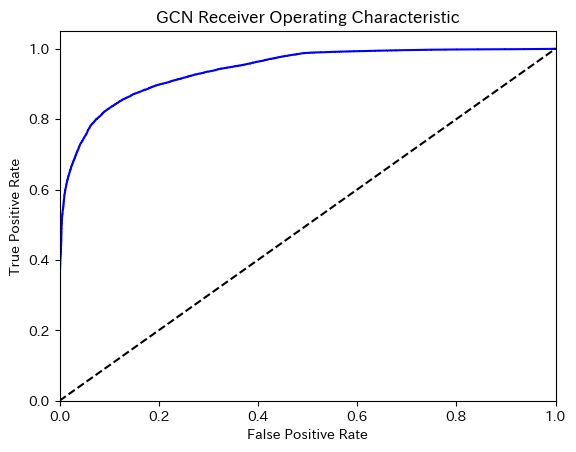

AUC Score: 0.9412
Accuracy: 0.8655
Precision: 0.8958
Recall: 0.8272
Optimal Threshold: 0.6209
Positive edge predictions (mean): 0.8431
Negative edge predictions (mean): 0.5113


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve

# 学習済みモデルでリンク予測を実行
best_gcn_model.eval()
with torch.no_grad():
    # テストデータでの予測
    out = best_gcn_model(val_data.x, val_data.edge_index)

    # テスト用正のエッジでの予測
    num_pos_edges = val_data.edge_index.size(1)
    pos_edge_index = val_data.edge_index[:, :num_pos_edges]
    pos_embeddings_src = out[pos_edge_index[0]]
    pos_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)
    
    # テスト用負のエッジでの予測
    num_neg_edges = val_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=val_data.edge_index,
        num_nodes=val_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)

    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy() 

    # ラベルを作成
    pos_labels = torch.ones(pos_pred.size(0))  # 実際に存在するエッジなので1
    neg_labels = torch.zeros(neg_pred.size(0))  # 存在しないエッジなので0
    labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()

    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    valid_rocs["GCN"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    valid_rocs["GCN"]["fpr"] = fpr
    valid_rocs["GCN"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color="blue", label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('GCN Receiver Operating Characteristic')
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (predictions > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    valid_rocs["GCN"]["accuracy"] = accuracy
    valid_rocs["GCN"]["precision"] = precision
    valid_rocs["GCN"]["recall"] = recall
    
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### VGAEにおけるネットワーク生成

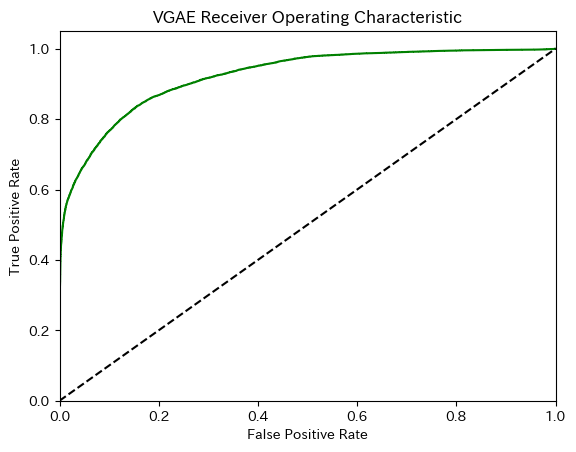

Val VGAE AUC Score: 0.9227
Accuracy: 0.8402
Optimal Threshold: 0.5809
Positive edge predictions (mean): 0.8130
Negative edge predictions (mean): 0.5273


In [ ]:
best_vgae_model.eval()
with torch.no_grad():
    z = best_vgae_model.encode(val_data.x, val_data.edge_index)  # エンコーダを使用して潜在ベクトルzを生成

    # 潜在ベクトルzをデコードして隣接行列を生成
    x = best_vgae_model.decode(z, val_data.edge_index)

    # 正エッジを予測
    num_pos_edges = val_data.edge_index.size(1)
    pos_edge_index = val_data.edge_index[:, :num_pos_edges]
    pos_pred = best_vgae_model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    num_neg_edges = val_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=val_data.edge_index, 
        num_nodes=val_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = best_vgae_model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)
    valid_rocs["VGAE"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)
    valid_rocs["VGAE"]["fpr"] = fpr
    valid_rocs["VGAE"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color="green", label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('VGAE Receiver Operating Characteristic')
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (preds.numpy() > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    valid_rocs["VGAE"]["accuracy"] = accuracy
    valid_rocs["VGAE"]["precision"] = precision
    valid_rocs["VGAE"]["recall"] = recall
    
    print(f"Val VGAE AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

**検証結果の比較**

GCN Validation Results:
AUC: 0.9412
Accuracy: 0.8655
Precision: 0.8958
Recall: 0.8272

VGAE Validation Results:
AUC: 0.9227
Accuracy: 0.8402
Precision: 0.8421
Recall: 0.8376


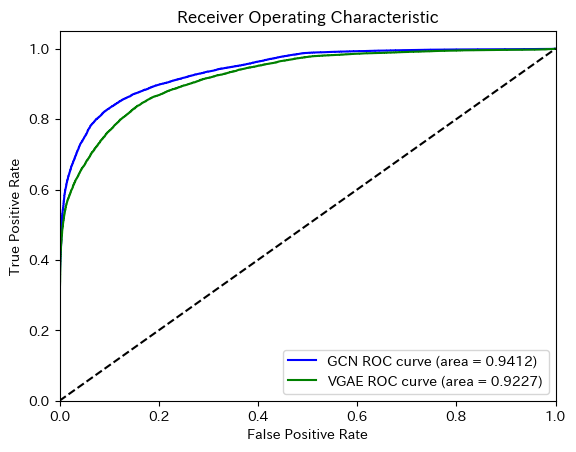

In [ ]:

print("GCN Validation Results:")
print(f"AUC: {valid_rocs['GCN']['auc']:.4f}")
print(f"Accuracy: {valid_rocs['GCN']['accuracy']:.4f}")
print(f"Precision: {valid_rocs['GCN']['precision']:.4f}")
print(f"Recall: {valid_rocs['GCN']['recall']:.4f}")
print("\nVGAE Validation Results:")
print(f"AUC: {valid_rocs['VGAE']['auc']:.4f}")
print(f"Accuracy: {valid_rocs['VGAE']['accuracy']:.4f}")
print(f"Precision: {valid_rocs['VGAE']['precision']:.4f}")
print(f"Recall: {valid_rocs['VGAE']['recall']:.4f}")

# GCNとVGAEのROC曲線をプロット
plt.figure()
plt.plot(valid_rocs["GCN"]["fpr"], valid_rocs["GCN"]["tpr"], color="blue", label='GCN ROC curve (area = {:.4f})'.format(valid_rocs["GCN"]["auc"]))
plt.plot(valid_rocs["VGAE"]["fpr"], valid_rocs["VGAE"]["tpr"], color="green", label='VGAE ROC curve (area = {:.4f})'.format(valid_rocs["VGAE"]["auc"]))
plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## テストデータによる検証

- コミュニティ萌芽期における取引データが少ないデータに対して取引予測を行い、GCNとVGAEの精度を比較評価する
- 学習や検証とは異なるテストデータを用いて検証しコミュニティの初期状態に対する予測やモデルの汎用性を評価する

In [ ]:

test_graph = nx.DiGraph()
test_graph.add_nodes_from(pd.concat([df_test_relation["from"], df_test_relation["to"]]).unique())
for index, transaction in df_test_relation.iterrows():
    test_graph.add_edge(transaction["from"], transaction["to"])
print(f"テストネットワーク: ノード数={test_graph.number_of_nodes()}, エッジ数={test_graph.number_of_edges()}")

テストネットワーク: ノード数=67, エッジ数=74


In [ ]:
# 中心性の計算
degree = nx.in_degree_centrality(test_graph)
betweenness = nx.betweenness_centrality(test_graph)
pagerank = nx.pagerank(test_graph)

# ガス代を集計
gas_from = df_test_relation.groupby('from')[['gasPrice', 'gasUsed']].sum()
gas_to = df_test_relation.groupby('to')[['gasPrice', 'gasUsed']].sum()
gas_combined = gas_from.add(gas_to, fill_value=0)

# ブロック番号を追加
block_from = df_test_relation.groupby('from')['blockNumber'].first()
block_to = df_test_relation.groupby('to')['blockNumber'].first()
block_combined = pd.concat([block_from, block_to]).groupby(level=0).first()

In [ ]:
df_test_feature = pd.DataFrame(
    index=list(test_graph.nodes),
    columns=["degree", "betweenness", "pagerank", "gasPrice", "gasUsed", "blockNumber"]
)

# データフレームに追加
for node in df_test_feature.index:
    if node in degree:
        df_test_feature.loc[node, "degree"] = degree[node]
    if node in betweenness:
        df_test_feature.loc[node, "betweenness"] = betweenness[node]
    if node in pagerank:
        df_test_feature.loc[node, "pagerank"] = pagerank[node]
    if node in gas_combined.index:
        df_test_feature.loc[node, 'gasPrice'] = gas_combined.loc[node, 'gasPrice']
        df_test_feature.loc[node, 'gasUsed'] = gas_combined.loc[node, 'gasUsed']
    if node in block_combined.index:
        df_test_feature.loc[node, 'blockNumber'] = block_combined.loc[node]

# CSVに保存
df_test_feature.to_csv(data_url+"test-features.csv", index=True)

# 標準化
df_test_feature = (df_test_feature - df_test_feature.mean()) / df_test_feature.std()

# データ型の変換
df_test_feature = df_test_feature.astype({
    "degree": "float32",
    "betweenness": "float32",
    "pagerank": "float32",
    "gasPrice": "float32",
    "gasUsed": "float32",
    "blockNumber": "float32",
})

# 結果の表示
display(df_test_feature.head())

,degree,betweenness,pagerank,gasPrice,gasUsed,blockNumber
0x3ED87449591524deF3A2f9aeA247dcD3BD38687f,1.176053,7.590601,-0.000849,5.469034,5.469034,-1.048578
0xb7C4DD1CC46FAc3163dD62538596B84951d00d19,1.176053,-0.274699,2.492552,0.158523,0.158523,-1.048151
0x5e33CF3a0aE32A349F537E596cCd89e4C7385B0b,1.176053,1.062402,-0.207479,0.061968,0.061968,-0.813918
0xeb5B2943eb3aeCef8fC4DC69BE6F6Fd106c479Dd,1.176053,-0.274699,2.492552,0.061968,0.061968,-1.048224
0x94CA43ff64CFE538fC202905736dF5309d97ab4D,-0.137206,0.826443,-0.440933,1.027516,1.027516,-0.852106


In [ ]:
# ノードのユニークIDを取得し、ノードのインデックスを辞書として作成
unique_nodes = pd.concat([df_test_relation['from'], df_test_relation['to']]).unique()
node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}

# pytorch_geometricに変換
edge_index = torch.tensor(
    [[node_to_index[row['from']], node_to_index[row['to']]] for _, row in df_test_relation.iterrows()],
    dtype=torch.long
).t().contiguous()

# ノードの特徴量をdf_test_featureから取得
x = torch.tensor(df_test_feature.loc[unique_nodes].values, dtype=torch.float)
test_data = Data(x=x, edge_index=edge_index)
test_data = test_data.to(device)

In [ ]:
test_rocs = {
    "GCN": {
        "fpr": [], "tpr": [], "auc": 0.0, "accuracy": 0.0, "precision": 0.0, "recall": 0.0
    },
    "VGAE": {
        "fpr": [], "tpr": [], "auc": 0.0, "accuracy": 0.0, "precision": 0.0, "recall": 0.0
    }
}

### GCNを用いたリンク予測

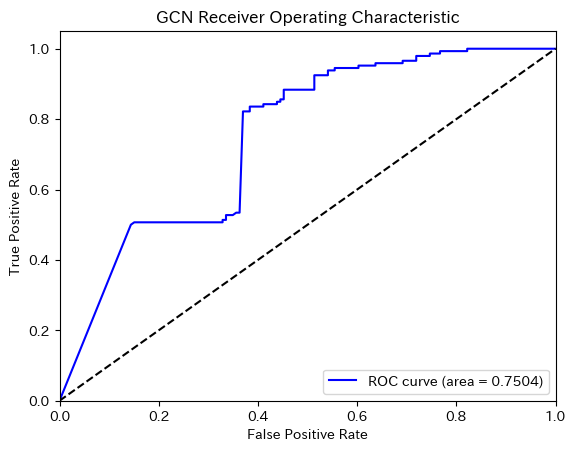

AUC Score: 0.7504
Accuracy: 0.7226
Precision: 0.6836
Recall: 0.8288
Optimal Threshold: 1.0000
Positive edge predictions (mean): 0.9687
Negative edge predictions (mean): 0.7823


In [ ]:
gcn_predict_edges = []

# 学習済みモデルでリンク予測を実行
best_gcn_model.eval()
with torch.no_grad():
    # テストデータでの予測
    out = best_gcn_model(test_data.x, test_data.edge_index)

    # テスト用正のエッジでの予測
    num_pos_edges = test_data.edge_index.size(1)
    pos_edge_index = test_data.edge_index[:, :num_pos_edges]
    pos_embeddings_src = out[pos_edge_index[0]]
    pos_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)
    
    # テスト用負のエッジでの予測
    num_neg_edges = test_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index,
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)

    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy() 

    # ラベルを作成
    pos_labels = torch.ones(pos_pred.size(0))  # 実際に存在するエッジなので1
    neg_labels = torch.zeros(neg_pred.size(0))  # 存在しないエッジなので0
    labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()

    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    test_rocs["GCN"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    test_rocs["GCN"]["fpr"] = fpr
    test_rocs["GCN"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('GCN Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (predictions > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    test_rocs["GCN"]["accuracy"] = accuracy
    test_rocs["GCN"]["precision"] = precision
    test_rocs["GCN"]["recall"] = recall

    # エッジを保存
    gcn_predict_edges = [(pos_edge_index[0,i].item(), pos_edge_index[1,i].item(), pos_pred[i].item()) for i in range(pos_edge_index.size(1))]
    
    # 結果の表示
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### VGAEを用いたリンク予測

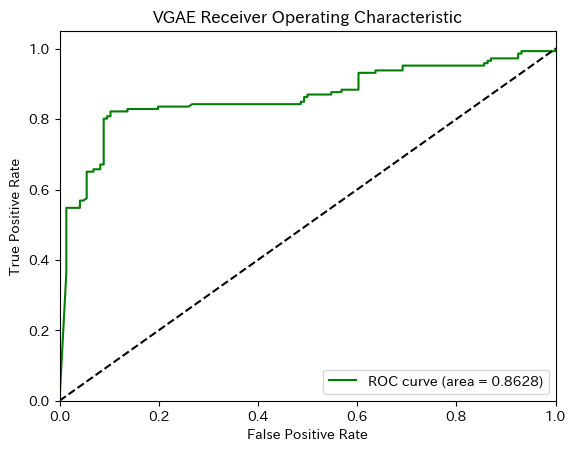

Val VGAE AUC Score: 0.8628
Accuracy: 0.8562
Precision: 0.8881
Recall: 0.8151
Optimal Threshold: 0.9991
Positive edge predictions (mean): 0.9805
Negative edge predictions (mean): 0.9191


In [ ]:
vgae_predict_edges = []

best_vgae_model.eval()
with torch.no_grad():
    z = best_vgae_model.encode(test_data.x, test_data.edge_index)  # エンコーダを使用して潜在ベクトルzを生成

    # 潜在ベクトルzをデコードして隣接行列を生成
    x = best_vgae_model.decode(z, test_data.edge_index)

    # 正エッジを予測
    num_pos_edges = test_data.edge_index.size(1)
    pos_edge_index = test_data.edge_index[:, :num_pos_edges]
    pos_pred = best_vgae_model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    num_neg_edges = test_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index, 
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_pred = best_vgae_model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0)

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)
    test_rocs["VGAE"]["auc"] = auc_score

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)
    test_rocs["VGAE"]["fpr"] = fpr
    test_rocs["VGAE"]["tpr"] = tpr

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, color="green", label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('VGAE Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (preds.numpy() > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    test_rocs["VGAE"]["accuracy"] = accuracy
    test_rocs["VGAE"]["precision"] = precision
    test_rocs["VGAE"]["recall"] = recall

    # エッジを保存
    prob = torch.sigmoid(z @ z.t())
    adj_matrix = (prob > optimal_threshold).nonzero(as_tuple=False).t().cpu()
    adj_matrix = adj_matrix[:, torch.randperm(adj_matrix.size(1))[:val_data.num_edges]]
    vgae_predict_edges = adj_matrix.t().numpy()
    
    print(f"Val VGAE AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### 検証結果の比較

- GCNとVGAEのリンク予測の検証結果を比較
- AUC・Accuracy・Precision・RecallとROC曲線の比較

GCN Test Results:
AUC: 0.7504
Accuracy: 0.7226
Precision: 0.6836
Recall: 0.8288

VGAE Test Results:
AUC: 0.8628
Accuracy: 0.8562
Precision: 0.8881
Recall: 0.8151


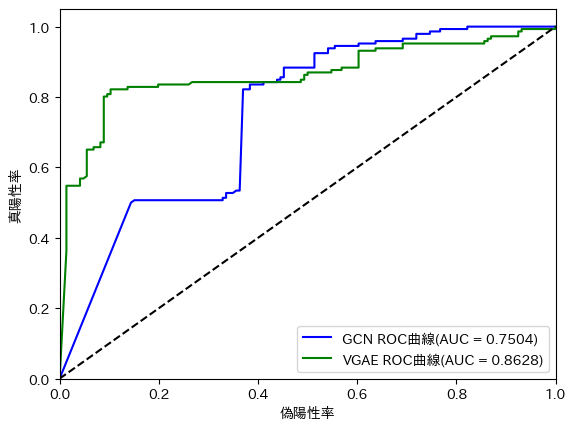

In [29]:
# 結果の表示
print("GCN Test Results:")
print(f"AUC: {test_rocs['GCN']['auc']:.4f}")
print(f"Accuracy: {test_rocs['GCN']['accuracy']:.4f}")
print(f"Precision: {test_rocs['GCN']['precision']:.4f}")
print(f"Recall: {test_rocs['GCN']['recall']:.4f}")
print("\nVGAE Test Results:")
print(f"AUC: {test_rocs['VGAE']['auc']:.4f}")
print(f"Accuracy: {test_rocs['VGAE']['accuracy']:.4f}")
print(f"Precision: {test_rocs['VGAE']['precision']:.4f}")
print(f"Recall: {test_rocs['VGAE']['recall']:.4f}")

# GCNとVGAEのROC曲線をプロット
plt.figure()
plt.plot(test_rocs["GCN"]["fpr"], test_rocs["GCN"]["tpr"], color="blue", label='GCN ROC曲線(AUC = {:.4f})'.format(test_rocs["GCN"]["auc"]))
plt.plot(test_rocs["VGAE"]["fpr"], test_rocs["VGAE"]["tpr"], color="green", label='VGAE ROC曲線(AUC = {:.4f})'.format(test_rocs["VGAE"]["auc"]))
plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('偽陽性率')
plt.ylabel('真陽性率')
plt.legend(loc="lower right")
plt.savefig(data_url + "roc-curve.png")
plt.show()

## 中心性の比較

- コミュニティ萌芽期における取引ネットワークを活用
- リンク予測により作成されたグラフの結果に対して中心性を算出
- 中心性分布を比較することでユーザーのつながり度合いが現れていることを検証する

In [30]:
# GCNで予測したエッジからグラフを生成
gcn_gen_graph = nx.DiGraph()
gcn_gen_graph.add_nodes_from(list(test_graph.nodes))
for edge in gcn_predict_edges:
    gcn_gen_graph.add_edge(edge[0], edge[1])

# VGAEで予測したエッジからグラフを生成
vgae_gen_graph = nx.DiGraph()
vgae_gen_graph.add_nodes_from(list(test_graph.nodes))
for edge in vgae_predict_edges:
    vgae_gen_graph.add_edge(edge[0], edge[1])

# ノード数とエッジ数を表示
print(f"Original: nodes={test_graph.number_of_nodes()}, edges={test_graph.number_of_edges()}")
print(f"GCN: nodes={gcn_gen_graph.number_of_nodes()}, edges={gcn_gen_graph.number_of_edges()}")
print(f"VGAE: nodes={vgae_gen_graph.number_of_nodes()}, edges={vgae_gen_graph.number_of_edges()}")

Original: nodes=67, edges=74
GCN: nodes=134, edges=74
VGAE: nodes=133, edges=762


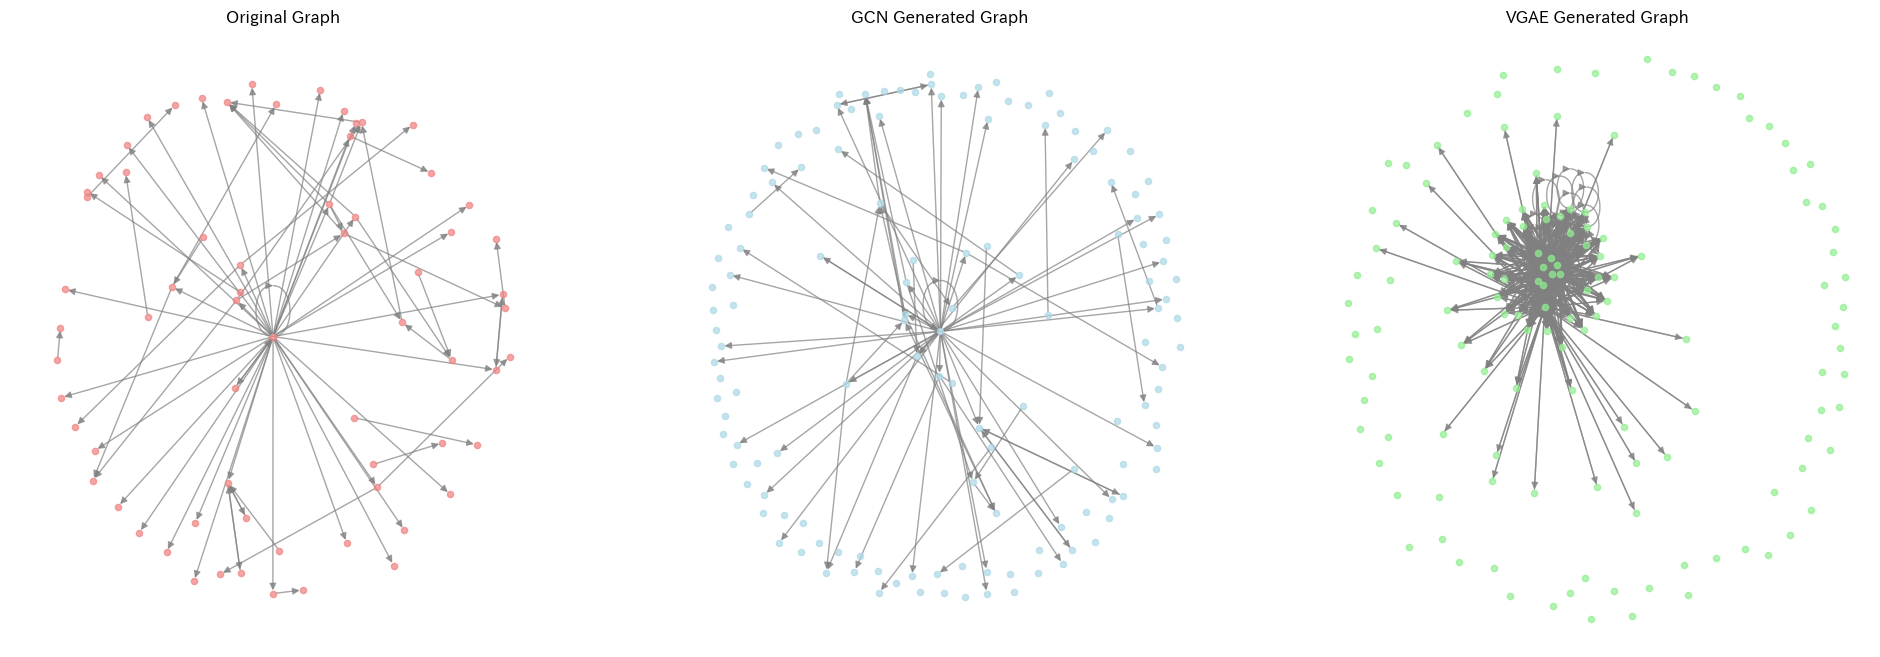

In [31]:
# グラフを可視化
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
pos_original = nx.spring_layout(test_graph, k=0.5, iterations=50)
nx.draw(test_graph, pos_original, with_labels=False, node_size=20, node_color='lightcoral', edge_color='gray', alpha=0.7)
plt.title("Original Graph")
plt.subplot(1, 3, 2)
pos_gcn = nx.spring_layout(gcn_gen_graph, k=0.5, iterations=50)
nx.draw(gcn_gen_graph, pos_gcn, with_labels=False, node_size=20, node_color='lightblue', edge_color='gray', alpha=0.7)
plt.title("GCN Generated Graph")
plt.subplot(1, 3, 3)
pos_vgae = nx.spring_layout(vgae_gen_graph, k=0.5, iterations=50)
nx.draw(vgae_gen_graph, pos_vgae, with_labels=False, node_size=20, node_color='lightgreen', edge_color='gray', alpha=0.7)
plt.title("VGAE Generated Graph")
plt.show()

### ネットワークの中心性を求める
- 元のグラフとGCN、VGAEのグラフの中心性を算出
- 算出した中心性をDataFrameに保存

In [ ]:
# オリジナル(元)のグラフの中心性指標を計算
original_degree = nx.in_degree_centrality(test_graph)
original_betweenness = nx.betweenness_centrality(test_graph)
original_pagerank = nx.pagerank(test_graph)

# GCNで生成したグラフの中心性指標を計算
gcn_degree = nx.in_degree_centrality(gcn_gen_graph)
gcn_betweenness = nx.betweenness_centrality(gcn_gen_graph)
gcn_pagerank = nx.pagerank(gcn_gen_graph)

# VGAEで生成したグラフの中心性指標を計算
vgae_degree = nx.in_degree_centrality(vgae_gen_graph)
vgae_betweenness = nx.betweenness_centrality(vgae_gen_graph)
vgae_pagerank = nx.pagerank(vgae_gen_graph)

In [ ]:
# 中心性データを効率的に集約
centrality_data = {
    "original": {"degree": original_degree, "betweenness": original_betweenness, "pagerank": original_pagerank},
    "gcn": {"degree": gcn_degree, "betweenness": gcn_betweenness, "pagerank": gcn_pagerank},
    "vgae": {"degree": vgae_degree, "betweenness": vgae_betweenness, "pagerank": vgae_pagerank}
}

# リスト内包表記で一括処理
centrality_list = [
    [graph_type, centrality_type, value]
    for graph_type, centralities in centrality_data.items()
    for centrality_type, centrality_dict in centralities.items()
    for value in centrality_dict.values()
]

# データフレームを作成
df_centrality = pd.DataFrame(centrality_list, columns=["type", "variable", "value"])
df_centrality = df_centrality.astype({
    "type": "category",
    "variable": "category", 
    "value": "float32"
})

In [34]:
for type in ["original", "gcn", "vgae"]:
    print(f"--- {type} ---")
    for variable in ["degree", "betweenness", "pagerank"]:
        mean = df_centrality[(df_centrality['type'] == type) & (df_centrality['variable'] == variable)]['value'].mean()
        std = df_centrality[(df_centrality['type'] == type) & (df_centrality['variable'] == variable)]['value'].std()
        print(f"{variable}: mean={mean:.4f}, std={std:.4f}")

--- original ---
degree: mean=0.0167, std=0.0115
betweenness: mean=0.0004, std=0.0015
pagerank: mean=0.0149, std=0.0156
--- gcn ---
degree: mean=0.0042, std=0.0058
betweenness: mean=0.0000, std=0.0003
pagerank: mean=0.0075, std=0.0076
--- vgae ---
degree: mean=0.0434, std=0.0873
betweenness: mean=0.0015, std=0.0118
pagerank: mean=0.0075, std=0.0125


**元のグラフの中心性を可視化**

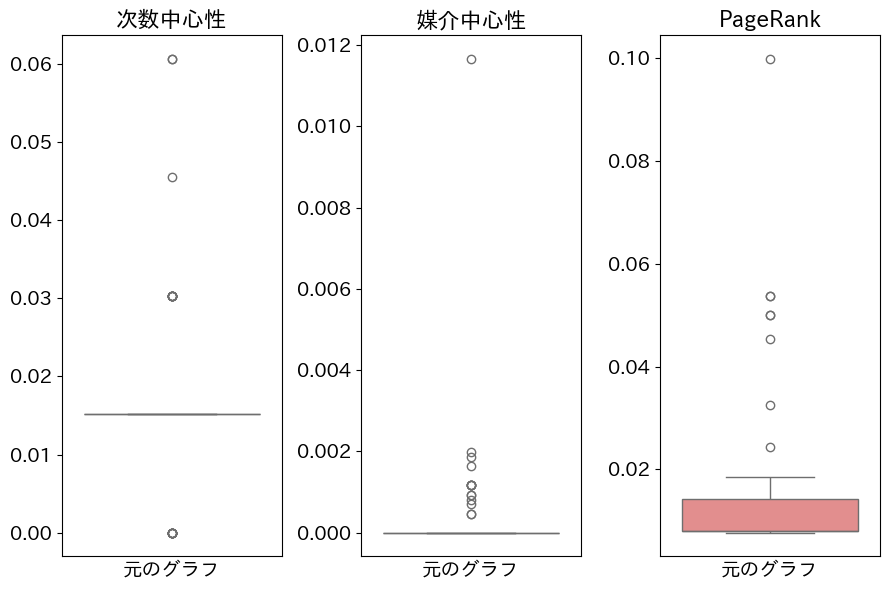

In [35]:
import seaborn as sns

# サブプロットで各中心性を別々に表示
fig, axes = plt.subplots(1, 3, figsize=(9, 6))
centrality_types = ['degree', 'betweenness', 'pagerank']
for i, centrality_type in enumerate(centrality_types):
    # 元のグラフの該当する中心性のデータのみを抽出
    data_subset = df_centrality[(df_centrality['variable'] == centrality_type) & (df_centrality['type'] == 'original')]

    # 箱ひげ図を描画
    sns.boxplot(
        y='value', 
        data=data_subset, 
        ax=axes[i],
        color='lightcoral'
    )

    # タイトルとラベルの設定
    if centrality_type == 'degree':
        axes[i].set_title('次数中心性', fontsize=16)
    elif centrality_type == 'betweenness':
        axes[i].set_title('媒介中心性', fontsize=16)
    else:
        axes[i].set_title('PageRank', fontsize=16)
    axes[i].set_xlabel('元のグラフ', fontsize=14)
    axes[i].set_ylabel('', fontsize=14)
    axes[i].tick_params(axis='y', labelsize=14)
    axes[i].set_xticks([])

plt.tight_layout()
plt.savefig(data_url + "original-centrality-boxplots.png")
plt.show()

### 元のグラフとVGAEのグラフの中心性を比較

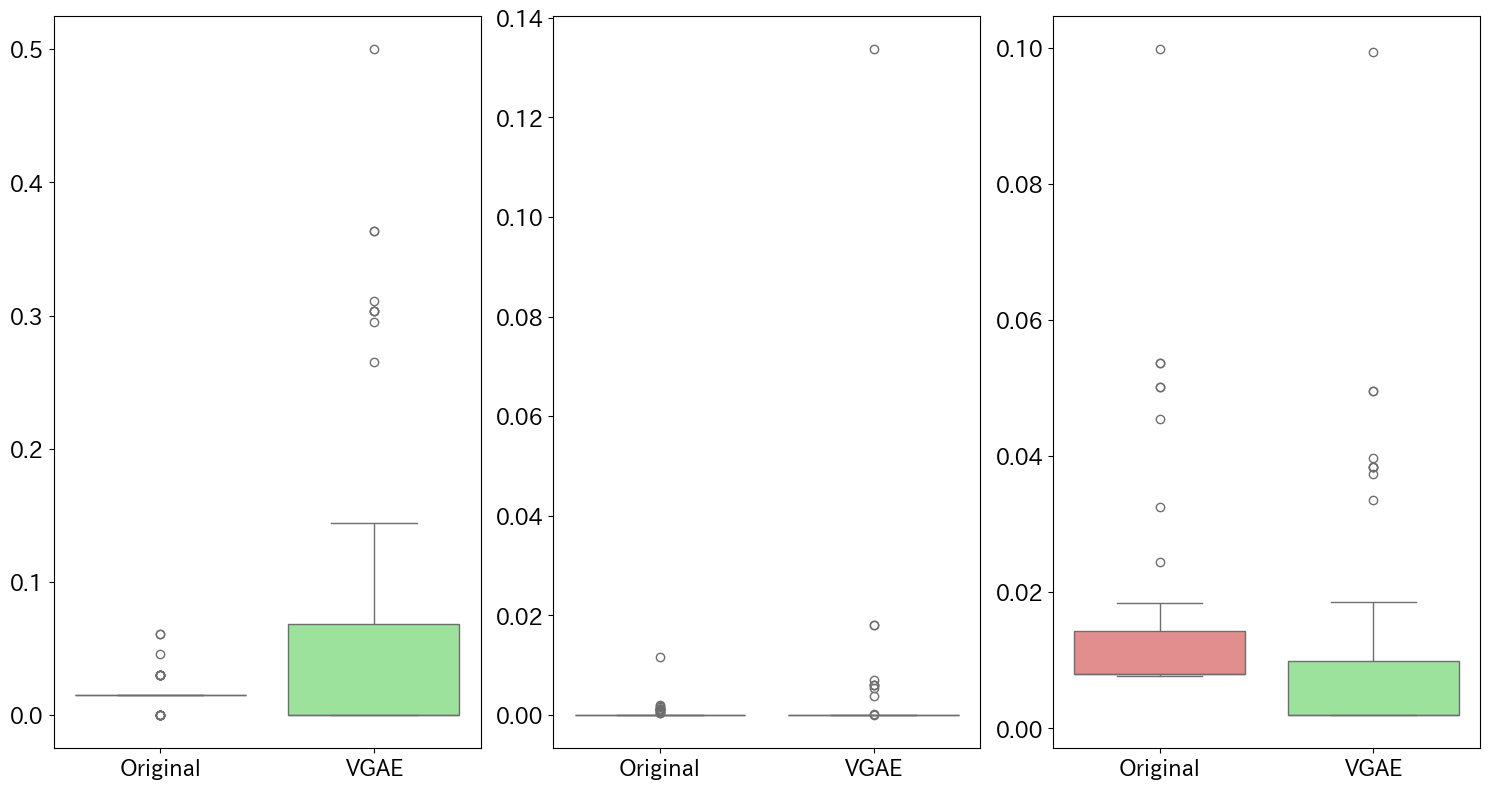

In [36]:
# サブプロットで各中心性を別々に表示
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# 各中心性指標ごとにプロット
centrality_types = ['degree', 'betweenness', 'pagerank']
x_order = ['original', 'vgae']

for i, centrality_type in enumerate(centrality_types):
    # 該当する中心性のデータのみを抽出
    data_subset = df_centrality[(df_centrality['variable'] == centrality_type) & (df_centrality['type'].isin(x_order))].copy()
    # カテゴリ型を再設定
    data_subset['type'] = data_subset['type'].cat.remove_unused_categories()

    # 箱ひげ図を描画
    sns.boxplot(
        x='type', 
        y='value', 
        data=data_subset, 
        ax=axes[i], 
        order=x_order,
        hue='type',
        palette={"original": "lightcoral", "vgae": "lightgreen"}
    )

    # タイトルとラベルの設定
    if centrality_type == 'degree':
        axes[i].set_ylabel('次数中心性', fontsize=16)
    elif centrality_type == 'betweenness':
        axes[i].set_ylabel('媒介中心性', fontsize=16)
    else:
        axes[i].set_ylabel('PageRank', fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('', fontsize=16)
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["Original", "VGAE"], fontsize=16)

plt.tight_layout()
plt.savefig(data_url + "original-vgae-centrality-boxplots.png")
plt.show()

### GCNとVGAEの中心性を比較

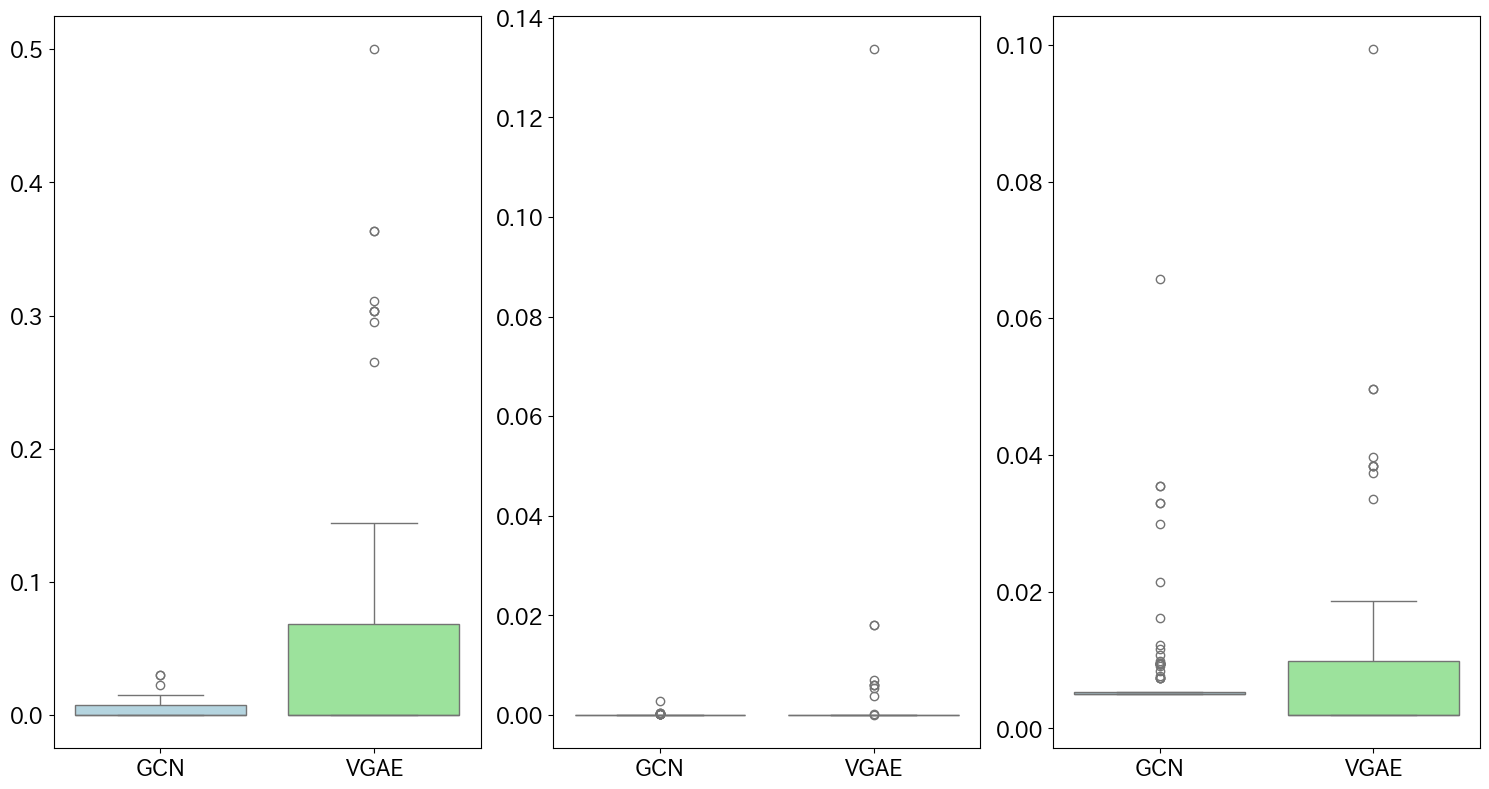

In [37]:
# サブプロットで各中心性を別々に表示
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# 各中心性指標ごとにプロット
centrality_types = ['degree', 'betweenness', 'pagerank']
x_order = ['gcn', 'vgae']

for i, centrality_type in enumerate(centrality_types):
    # 該当する中心性のデータのみを抽出
    data_subset = df_centrality[(df_centrality['variable'] == centrality_type) & (df_centrality['type'].isin(x_order))].copy()
    # カテゴリ型を再設定
    data_subset['type'] = data_subset['type'].cat.remove_unused_categories()

    # 箱ひげ図を描画
    sns.boxplot(
        x='type', 
        y='value', 
        data=data_subset, 
        ax=axes[i], 
        order=x_order,
        hue='type',
        palette={"gcn": "lightblue", "vgae": "lightgreen"}
    )

    # タイトルとラベルの設定
    if centrality_type == 'degree':
        axes[i].set_ylabel('次数中心性', fontsize=16)
    elif centrality_type == 'betweenness':
        axes[i].set_ylabel('媒介中心性', fontsize=16)
    else:
        axes[i].set_ylabel('PageRank', fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('', fontsize=16)
    axes[i].tick_params(axis='y', labelsize=16)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["GCN", "VGAE"], fontsize=16)

plt.tight_layout()
plt.savefig(data_url + "gcn-vgae-centrality-boxplots.png")
plt.show()